In [ ]:
import os
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from huggingface_hub.hf_api import HfFolder
from pathlib import Path
from pprint import pprint

import logging
logging.getLogger().setLevel(logging.WARNING)


Hf_token = "YOUR-TOKEN"
HfFolder.save_token(Hf_token)

In [ ]:
# check if the enviroment is kaggle or local

DATASET_PATH = Path('/kaggle/input/')
if not DATASET_PATH.exists():
    DATASET_PATH = Path('.')
DATASET_PATH /= 'rai-bioml-2024'

### LLM inference

In [6]:
import transformers
import torch
class Server:
    def __init__(self): 
        model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
        self.pipeline = transformers.pipeline(
            "text-generation",
            model=model_id,
            model_kwargs={"torch_dtype": torch.bfloat16},
            device_map="auto",
        )
        self.chat_context = []
    
    def add_system_context(self, message):
        if len(self.chat_context) == 0:
            self.chat_context.insert(0,{"role": "system", "content": message})
        else:
            if self.chat_context[0]["role"] == "system":
                self.chat_context[0]["content"] = message
            else:
                self.chat_context.insert(0,{"role": "system", "content": message})
    
    def add_user_ontext(self, message):
        self.chat_context.append({"role": "user", "content": message})
        
    def add_model_context(self, message):
        self.chat_context.append({"role": "assistant", "content": message})
        
    def ask_question(self, message, add_context=False):
        outputs = self.pipeline(
            self.chat_context + [{'role':'user', "content":message}],
            max_new_tokens=256,
        )
        if add_context:
            self.add_user_context(message)
            self.add_model_context(outputs[0]["generated_text"][-1]["content"])
        return outputs[0]["generated_text"][-1]['content']





In [ ]:
from openai import OpenAI
from pydantic import BaseModel

class ResponseFormat(BaseModel):
    answer: bool
    # reasoning: str

class OPEN_AI_Server:
    def __init__(self, api_key: str=None):
        """
        Initialize the server with an OpenAI API key.
        """
        self.client = OpenAI(api_key=api_key)
        self.chat_context = []

    def add_system_context(self, message: str):
        """
        Add or update the system context in the chat history.
        If a system message exists, it will be updated; otherwise, it will be added.
        """
        if len(self.chat_context) == 0 or self.chat_context[0]["role"] != "system":
            self.chat_context.insert(0, {"role": "system", "content": message})
        else:
            self.chat_context[0]["content"] = message

    def add_user_context(self, message: str):
        """
        Add a user message to the chat context.
        """
        self.chat_context.append({"role": "user", "content": message})

    def add_model_context(self, message: str):
        """
        Add a model-generated message to the chat context.
        """
        self.chat_context.append({"role": "assistant", "content": message})

    def ask_question(self, message: str, add_context: bool = False,
                     temperature: float = 0.5, max_tokens: int = 100,
                     top_p: float = 1.0, model: str = "gpt-4o-mini"
                     ) -> ResponseFormat:
        """
        Send a user query to the OpenAI model and optionally update the chat context.

        Args:
            message (str): The user message to process.
            add_context (bool): Whether to update the chat context with the user query and model response.

        Returns:
            ResponseFormat: A structured response containing the answer and reasoning.
        """
        try:
            messages = self.chat_context + [{"role": "user", "content": message}]

            completion = self.client.beta.chat.completions.parse(
                model=model,
                messages=messages,
                max_tokens=max_tokens,
                temperature=temperature,
                top_p=top_p,
                response_format=ResponseFormat,
            )

            # if add_context:
                # self.add_model_context(f"Answer: {completion.answer}\nReasoning: {completion.reasoning}")

            return completion
        except Exception as e:
            return ResponseFormat(answer=None, reasoning=f"Error occured: {str(e)}")
        
    def clear_context(self):
        """
        Clear the chat context.
        """
        self.chat_context = []


In [8]:
server = OPEN_AI_Server()

server.add_system_context("You are a helpful assistant specialized in geography")

print(f"Server context: {server.chat_context}")
prompt = "Is London the capital of France?"
response = server.ask_question(prompt, temperature=0, max_tokens=50)
print(response)


Server context: [{'role': 'system', 'content': 'You are a helpful assistant specialized in geography'}]
ParsedChatCompletion[ResponseFormat](id='chatcmpl-Act25w7KBf272dsNf6QSWGxEHvXOR', choices=[ParsedChoice[ResponseFormat](finish_reason='stop', index=0, logprobs=None, message=ParsedChatCompletionMessage[ResponseFormat](content='{"answer":false}', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[], parsed=ResponseFormat(answer=False)))], created=1733831373, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_bba3c8e70b', usage=CompletionUsage(completion_tokens=5, prompt_tokens=62, total_tokens=67, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))


## Ontology access

In [5]:
# !pip install owlready2
# !pip install rdflib

In [ ]:
from owlready2 import *
import rdflib
from enum import Enum

In [10]:
class AnnotationURIs(object):
    '''
    This class manages the most common ontology annotations
    '''

    def __init__(self):       
        self.mainLabelURIs = set()
        self.synonymLabelURIs = set()
        self.lexicalAnnotationURIs = set()      
                        
        #Main labels
        self.mainLabelURIs.add("http://www.w3.org/2000/01/rdf-schema#label")
        self.mainLabelURIs.add("http://www.w3.org/2004/02/skos/core#prefLabel")
        self.mainLabelURIs.add("http://purl.obolibrary.org/obo/IAO_0000111")
        self.mainLabelURIs.add("http://purl.obolibrary.org/obo/IAO_0000589")

        #synonyms or alternative names
        self.synonymLabelURIs.add("http://www.geneontology.org/formats/oboInOwl#hasRelatedSynonym")
        self.synonymLabelURIs.add("http://www.geneontology.org/formats/oboInOwl#hasExactSynonym")
        self.synonymLabelURIs.add("http://www.geneontology.org/formats/oboInOWL#hasExactSynonym")
        self.synonymLabelURIs.add("http://www.geneontology.org/formats/oboInOwl#hasRelatedSynonym")
        self.synonymLabelURIs.add("http://purl.bioontology.org/ontology/SYN#synonym")
        self.synonymLabelURIs.add("http://scai.fraunhofer.de/CSEO#Synonym")
        self.synonymLabelURIs.add("http://purl.obolibrary.org/obo/synonym")
        self.synonymLabelURIs.add("http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus.owl#FULL_SYN")
        self.synonymLabelURIs.add("http://www.ebi.ac.uk/efo/alternative_term")
        self.synonymLabelURIs.add("http://ncicb.nci.nih.gov/xml/owl/EVS/Thesaurus.owl#Synonym")
        self.synonymLabelURIs.add("http://bioontology.org/projects/ontologies/fma/fmaOwlDlComponent_2_0#Synonym")
        self.synonymLabelURIs.add("http://www.geneontology.org/formats/oboInOwl#hasDefinition")
        self.synonymLabelURIs.add("http://bioontology.org/projects/ontologies/birnlex#preferred_label")
        self.synonymLabelURIs.add("http://bioontology.org/projects/ontologies/birnlex#synonyms")
        self.synonymLabelURIs.add("http://www.w3.org/2004/02/skos/core#altLabel")
        self.synonymLabelURIs.add("https://cfpub.epa.gov/ecotox#latinName")
        self.synonymLabelURIs.add("https://cfpub.epa.gov/ecotox#commonName")
        self.synonymLabelURIs.add("https://www.ncbi.nlm.nih.gov/taxonomy#scientific_name")
        self.synonymLabelURIs.add("https://www.ncbi.nlm.nih.gov/taxonomy#synonym")
        self.synonymLabelURIs.add("https://www.ncbi.nlm.nih.gov/taxonomy#equivalent_name")
        self.synonymLabelURIs.add("https://www.ncbi.nlm.nih.gov/taxonomy#genbank_synonym")
        self.synonymLabelURIs.add("https://www.ncbi.nlm.nih.gov/taxonomy#common_name")       

        #Alternative term       
        self.synonymLabelURIs.add("http://purl.obolibrary.org/obo/IAO_0000118")
        #Mouse anatomy
        #Lexically rich interesting
        self.lexicalAnnotationURIs.update(self.mainLabelURIs)
        self.lexicalAnnotationURIs.update(self.synonymLabelURIs)
        self.lexicalAnnotationURIs.add("http://www.w3.org/2000/01/rdf-schema#comment")
        self.lexicalAnnotationURIs.add("http://www.geneontology.org/formats/oboInOwl#hasDbXref")
        self.lexicalAnnotationURIs.add("http://purl.org/dc/elements/1.1/description")
        self.lexicalAnnotationURIs.add("http://purl.org/dc/terms/description")
        self.lexicalAnnotationURIs.add("http://purl.org/dc/elements/1.1/title")
        self.lexicalAnnotationURIs.add("http://purl.org/dc/terms/title")

        #Definition
        self.lexicalAnnotationURIs.add("http://purl.obolibrary.org/obo/IAO_0000115")
        #Elucidation
        self.lexicalAnnotationURIs.add("http://purl.obolibrary.org/obo/IAO_0000600")
        #has associated axiomm fol
        self.lexicalAnnotationURIs.add("http://purl.obolibrary.org/obo/IAO_0000602")
        #has associated axiomm nl
        self.lexicalAnnotationURIs.add("http://purl.obolibrary.org/obo/IAO_0000601")
        self.lexicalAnnotationURIs.add("http://www.geneontology.org/formats/oboInOwl#hasOBONamespace")

    def getAnnotationURIsForPreferredLabels(self):
        return self.mainLabelURIs
    
    def getAnnotationURIsForSymnonyms(self):
        return self.synonymLabelURIs

    def getAnnotationURIsForLexicalAnnotations(self):
        return self.lexicalAnnotationURIs


In [ ]:
class Reasoner(Enum):
    HERMIT=0 #Not really adding the right set of entailments
    PELLET=1 #Slow for large ontologies
    STRUCTURAL=2  #Basic domain/range propagation
    NONE=3 #No reasoning

class OntologyAccess(object):

    def __init__(self, urionto, annotate_on_init=True):
        logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.WARNING)
        self.urionto = str(urionto)
        if annotate_on_init:
            self.loadOntology()
            self.indexAnnotations()

    def getOntologyIRI(self):
        return self.urionto

    def loadOntology(self, reasoner=Reasoner.NONE, memory_java='10240'):
        #Method from owlready
        self.onto = get_ontology(self.urionto).load()
        owlready2.reasoning.JAVA_MEMORY=memory_java
        owlready2.set_log_level(9)

        if reasoner==Reasoner.PELLET:
            try:
                with self.onto:  #it does add inferences to ontology

                    # Is this wrt data assertions? Check if necessary
                    # infer_property_values = True, infer_data_property_values = True
                    logging.info("Classifying ontology with Pellet...")
                    sync_reasoner_pellet() #it does add inferences to ontology
                    unsat = len(list(self.onto.inconsistent_classes()))
                    logging.info("Ontology successfully classified.")
                    if unsat > 0:
                        logging.warning("There are " + str(unsat) + " unsatisfiabiable classes.")
            except:
                logging.info("Classifying with Pellet failed.")

        elif reasoner==Reasoner.HERMIT:
                try:
                    with self.onto:  #it does add inferences to ontology
                        logging.info("Classifying ontology with HermiT...")
                        sync_reasoner() #HermiT doe snot work very well....
                        unsat = len(list(self.onto.inconsistent_classes()))
                        logging.info("Ontology successfully classified.")
                        if unsat > 0:
                            logging.warning("There are " + str(unsat) + " unsatisfiabiable classes.")
                except:
                    logging.info("Classifying with HermiT failed.")

        self.graph = default_world.as_rdflib_graph()
        logging.info("There are {} triples in the ontology".format(len(self.graph)))
        #self.graph = self.world.as_rdflib_graph()

    def getOntology(self):
        return self.onto

    def getClassByURI(self, uri):
        for cls in list(self.getOntology().classes()):
            if (cls.iri==uri):
                return cls
        return None

    def getClassByName(self, name):
        for cls in list(self.getOntology().classes()):
            if (cls.name.lower()==name.lower()):
                return cls
        return None

    def getEntityByURI(self, uri):
        for cls in list(self.getOntology().classes()):
            if (cls.iri==uri):
                return cls
        for prop in list(self.getOntology().properties()):
            if (prop.iri==uri):
                return prop
        return None

    def getEntityByName(self, name):
        for cls in list(self.getOntology().classes()):
            if (cls.name.lower()==name.lower()):
                return cls
        for prop in list(self.getOntology().properties()):
            if (prop.name.lower()==name.lower()):
                return prop
        return None

    def getClassObjectsContainingName(self, name):
        classes = []
        for cls in list(self.getOntology().classes()):
            if (name.lower() in cls.name.lower()):
                classes.append(cls)
        return classes

    def getClassIRIsContainingName(self, name):
        classes = []
        for cls in list(self.getOntology().classes()):
            if (name.lower() in cls.name.lower()):
                classes.append(cls.iri)
        return classes

    def getAncestorsURIsMinusClass(self,cls):
        ancestors_str = self.getAncestorsURIs(cls)
        ancestors_str.remove(cls.iri)
        return ancestors_str

    def getAncestorsURIs(self,cls):
        ancestors_str = set()
        for anc_cls in cls.ancestors():
            ancestors_str.add(anc_cls.iri)
        return ancestors_str

    def getAncestorsNames(self,cls):
        ancestors_str = set()
        for anc_cls in cls.ancestors():
            ancestors_str.add(anc_cls.name)
        return ancestors_str

    def getAncestors(self,cls):
        ancestors_str = set()
        for anc_cls in cls.ancestors():
            ancestors_str.add(anc_cls)
        return ancestors_str

    def getDescendantURIs(self,cls):
        descendants_str = set()
        for desc_cls in cls.descendants():
            descendants_str.add(desc_cls.iri)
        return descendants_str

    def getDescendantNames(self,cls):
        descendants_str = set()
        for desc_cls in cls.descendants():
            descendants_str.add(desc_cls.name)
        return descendants_str

    def getDescendants(self,cls):
        descendants_str = set()
        for desc_cls in cls.descendants():
            descendants_str.add(desc_cls)
        return descendants_str

    def getDescendantNamesForClassName(self, cls_name):
        cls = self.getClassByName(cls_name)
        descendants_str = set()
        for desc_cls in cls.descendants():
            descendants_str.add(desc_cls.name)
        return descendants_str

    def isSubClassOf(self, sub_cls1, sup_cls2):
        if sup_cls2 in sub_cls1.ancestors():
            return True
        return False

    def isSuperClassOf(self, sup_cls1, sub_cls2):
        if sup_cls1 in sub_cls2.ancestors():
            return True
        return False

    def getDomainURIs(self, prop):
        domain_uris = set()
        for cls in prop.domain:
            try:
                domain_uris.add(cls.iri)
            except AttributeError:
                pass
        return domain_uris

    def getDatatypeRangeNames(self, prop):
        range_uris = set()
        for cls in prop.range:
            range_uris.add(cls.name)  #datatypes are returned without uri
        return range_uris

    #Only for object properties
    def getRangeURIs(self, prop):
        range_uris = set()
        for cls in prop.range:
            try:
                range_uris.add(cls.iri)
            except AttributeError:
                pass
        return range_uris

    def getInverses(self, prop):
        inv_uris = set()
        for p in prop.inverse:
            inv_uris.add(p.iri)
        return inv_uris

    def getClasses(self):
        return self.getOntology().classes()

    def getDataProperties(self):
        return self.getOntology().data_properties()

    def getObjectProperties(self):
        return self.getOntology().object_properties()

    def getIndividuals(self):
        return self.getOntology().individuals()

    def getGraph(self):
        return self.graph

    def queryGraph(self, query):
        results = self.graph.query(query)
        return list(results)


    def getQueryForAnnotations(self, ann_prop_uri):
        return """SELECT DISTINCT ?s ?o WHERE {{
        {{
        ?s <{ann_prop}> ?o .
        }}
        UNION
        {{
        ?s <{ann_prop}> ?i .
        ?i <http://www.w3.org/2000/01/rdf-schema#label> ?o .
        }}
        }}""".format(ann_prop=ann_prop_uri)


    def indexAnnotations(self):
        annotation_uris = AnnotationURIs()
        self.entityToSynonyms = {}
        self.allEntityAnnotations = {}
        self.preferredLabels = {}
        self.populateAnnotationDicts(annotation_uris.getAnnotationURIsForSymnonyms(), self.entityToSynonyms)
        self.populateAnnotationDicts(annotation_uris.getAnnotationURIsForLexicalAnnotations(), self.allEntityAnnotations)
        self.populateAnnotationDicts(annotation_uris.getAnnotationURIsForPreferredLabels(), self.preferredLabels)

    def populateAnnotationDicts(self, annotation_uris, dictionary):
        for ann_prop_uri in annotation_uris:
            results = self.queryGraph(self.getQueryForAnnotations(ann_prop_uri))
            for row in results:
                try:
                    if row[1].language=="en" or row[1].language==None:
                        if not str(row[0]) in dictionary:
                            dictionary[str(row[0])]=set()
                        dictionary[str(row[0])].add(row[1].value)
                except AttributeError:
                    pass
        return None

    def getSynonymsNames(self, entity):
        if entity.iri not in self.entityToSynonyms: 
            return {}
        return self.entityToSynonyms[entity.iri]

    def getAnnotationNames(self, entity):
        if entity.iri not in self.allEntityAnnotations: 
            return {}
        return self.allEntityAnnotations[entity.iri]

    def getPrefferedLabels(self, entity):
        if entity.iri not in self.preferredLabels: 
            return {}
        return self.preferredLabels[entity.iri]


In [ ]:
src_onto_path = DATASET_PATH / 'omim-ordo/omim.owl'
tgt_onto_path = DATASET_PATH / 'omim-ordo/ordo.owl'

In [ ]:
onto_src = OntologyAccess(src_onto_path, annotate_on_init=False)
onto_src.loadOntology()
onto_src.indexAnnotations()

onto_tgt = OntologyAccess(tgt_onto_path, annotate_on_init=True)

In [10]:
# onto_classes = [x for x in onto_src.getClasses()]
# print(onto_classes[:25], type(onto_classes[0]))

# ancestors = {x:values for x in onto_src.getClasses() if len(values:=onto_src.getAncestors(x))>3}
# ancestors_labels = {'\n'.join(onto_src.getPrefferedLabels(x)):[
#     onto_src.getPrefferedLabels(y) for y in values] 
#                     for x, values in ancestors.items()}
# dict(list(ancestors_labels.items())[:5])

# descendants = {x: values for x in onto_src.getClasses() if len(values:=onto_src.getDescendants(x)) > 2}
# descendant_names = {'\n'.join(onto_src.getPrefferedLabels(x)): 
#             [onto_src.getPrefferedLabels(y) for y in values] for x, values in descendants.items()}
# dict(list(descendant_names.items())[:5])

# synonyms = {x:values for x in onto_src.getClasses() if len(values:=onto_src.getSynonymsNames(x))>0}
# dict(list(synonyms.items())[:10])

# annotation_labels = {x:values for x in onto_src.getClasses() if len(values:=onto_src.getAnnotationNames(x))>1}
# dict(list(annotation_labels.items())[:10])

# annotation_labels = {x:values for x in onto_tgt.getClasses() if len(values:=onto_tgt.getAnnotationNames(x))>2}
# dict(list(annotation_labels.items())[:10])

## Prompting

In [13]:
class OntologyEntryAttr:
    ## TODO: Add more attributes: direct children and parents
    def __init__(self, class_uri, onto: OntologyAccess, class_id=None):
        assert class_uri is not None or class_id is not None
        if class_uri is not None:
            self.class_id = onto.getClassByURI(class_uri)
        else:
            self.class_id = class_id
        assert self.class_id is not None
        self.annotation = {'class': self.class_id}
        self.onto:OntologyAccess = onto
        self.annotateEntry(onto)

    def annotateEntry(self, onto: OntologyAccess):
        logging.debug(f"Annotating {self.class_id}")
        self.annotation['children'] = onto.getDescendants(self.class_id)
        self.annotation['parents'] = onto.getAncestors(self.class_id)
        self.annotation['synonyms'] = onto.getSynonymsNames(self.class_id)
        self.annotation['names'] = onto.getAnnotationNames(self.class_id)

    def getAllEntetyNames(self):
        return self.annotation['names']

    def getSynonyms(self):
        return self.annotation['synonyms']
    
    def getChildren(self, skip_itself=True):
        result = self.annotation['children']
        if skip_itself:
            result = result.difference({self.class_id})
        return result

    def getParents(self, skip_itself=True):
        result = self.annotation['parents']
        if skip_itself:
            result = result.difference({self.class_id})
        return result

    def getParentsPreferredNames(self, skip_itself=True):
        labels = []
        for parent in self.getParents(skip_itself=skip_itself):
            preffered = self.onto.getPrefferedLabels(parent)
            if preffered:
                labels.append(preffered)
            else:
                labels.append({parent})
        return labels

    def getChildredPreferredNames(self, skip_itself=True):
        return [preffered if (preffered := self.onto.getPrefferedLabels(child)) else {child}
                for child in self.getChildren(skip_itself=skip_itself)]

    def __repr__(self):
        return str(self.annotation)

    def __str__(self):
        return str(self.annotation)

In [12]:
source_entity_uri = 'http://omim.org/entry/609560' #'http://omim.org/entry/100070'
target_entity_uri = 'http://www.orpha.net/ORDO/Orphanet_254875' #'http://omim.org/entry/101900'
source_entry = OntologyEntryAttr(source_entity_uri, onto_src)
target_entity = OntologyEntryAttr(target_entity_uri, onto_tgt)

DEBUG: Annotating entry.609560
DEBUG: Annotating ORDO.Orphanet_254875


In [13]:
display(source_entry)
print(target_entity)

{'class': entry.609560, 'children': {entry.609560}, 'parents': {owl.Thing, entry.609560, phenotypicSeries.PS603041}, 'synonyms': {'MTDPS2'}, 'names': {'mitochondrial DNA depletion syndrome 2 (myopathic type)', 'MTDPS2'}}

{'class': ORDO.Orphanet_254875, 'children': {ORDO.Orphanet_254875}, 'parents': {owl.Thing, ORDO.Orphanet_C001, ORDO.Orphanet_377788, ORDO.Orphanet_254875}, 'synonyms': {'mtDNA depletion syndrome, myopathic form'}, 'names': {'Mitochondrial DNA depletion syndrome, myopathic form', 'mtDNA depletion syndrome, myopathic form'}}


In [14]:
print(f" Source entity names: {source_entry.getAllEntetyNames()}")
print(f" Source entity synonyms: {source_entry.getSynonyms()}")
print(f" Source entity children names: {source_entry.getChildredPreferredNames(skip_itself=False)}")
print(f" Source entity children names: {source_entry.getChildredPreferredNames(skip_itself=True)}")
print(f" Source entity parents names: {source_entry.getParentsPreferredNames()}")
print(f" Source entity parents: {source_entry.getParents()}")

 Source entity names: {'mitochondrial DNA depletion syndrome 2 (myopathic type)', 'MTDPS2'}
 Source entity synonyms: {'MTDPS2'}
 Source entity children names: [{'mitochondrial DNA depletion syndrome 2 (myopathic type)'}]
 Source entity children names: []
 Source entity parents names: [{owl.Thing}, {'Mitochondrial DNA depletion syndrome'}]
 Source entity parents: {owl.Thing, phenotypicSeries.PS603041}


In [15]:
def composePrompt(source_entry:OntologyEntryAttr, target_entry:OntologyEntryAttr):
    return f"""
**Task Description:**
Given two sets of concepts with their names, parent relationships, and child relationships, determine if these concepts are identical. Evaluate based on the provided names and hierarchical structures.
**Template for Alignment:**

1. **Source Concept:**
**Names:** [List of source concept names]
**Parent Concepts:** [List of source concept's parent names]
**Child Concepts:** [List of source concept's child names]
2. **Target Concept:**
**Names:** [List of target concept names]
**Parent Concepts:** [List of target concept's parent names]
**Child Concepts:** [List of target concept's child names]
**Determine Concept Equivalence:**
Analyze whether the source and target concepts are equivalent based on names, parent concepts, and child concepts. Provide your conclusion ("Yes" for identical, "No" for different).

**Example Prompts (Few-Shot Examples):**

1. **Example 1:**
Source Concept Names: [e.g., "Entity_A"]
Parent of Source Concept: [e.g., "Parent_A"]
Child of Source Concept: [e.g., "Child_A"]
Target Concept Names: [e.g., "Entity_B"]
Parent of Target Concept: [e.g., "Parent_B"]
Child of Target Concept: [e.g., "Child_B"]

**Conclusion:** No

2. **Example 2:**
Source Concept Names: [e.g., "Entity_X"]
Parent of Source Concept: [e.g., "Parent_X"]
Child of Source Concept: [e.g., "Child_X"]
Target Concept Names: [e.g., "Entity_X"]
Parent of Target Concept: [e.g., "Parent_X"]
Child of Target Concept: [e.g., "Child_X"]
**Conclusion:** Yes
**Now Answer:**

Source Concept Names: {source_entry.getAllEntetyNames()}
Parent of Source Concept: {source_entry.getParentsPreferredNames()}
Child of Source Concept: {source_entry.getChildredPreferredNames()}
Target Concept Names: {target_entry.getAllEntetyNames()}
Parent of Target Concept: {target_entry.getParentsPreferredNames()}
Child of Target Concept: {target_entry.getChildredPreferredNames()}
""" 

In [16]:
source_entity_uri = 'http://omim.org/entry/609560' #'http://omim.org/entry/100070'
target_entity_uri = 'http://www.orpha.net/ORDO/Orphanet_254875' #'http://omim.org/entry/101900'
source_entity = OntologyEntryAttr(source_entity_uri, onto_src)
target_entity = OntologyEntryAttr(target_entity_uri, onto_tgt)
demo_prompt = composePrompt(source_entity, target_entity)
# print(demo_prompt)

DEBUG: Annotating entry.609560


DEBUG: Annotating ORDO.Orphanet_254875


In [17]:
# response = mistral.ask_question(demo_prompt)
# print(response)

## Local matching

In [ ]:
test_candidates_path = DATASET_PATH / "omim-ordo/refs_equiv/test.cands.tsv"
test_candidates = pd.read_csv(test_candidates_path, sep='\t')
test_candidates['TgtCandidates'] = test_candidates['TgtCandidates'].str.strip("('").str.strip("')").str.split("', '")

In [19]:
test_candidates.head()

,SrcEntity,TgtEntity,TgtCandidates
0,http://www.omim.org/phenotypicSeries/PS309510,http://www.orpha.net/ORDO/Orphanet_98464,"[http://www.orpha.net/ORDO/Orphanet_93406, htt..."
1,http://omim.org/entry/615075,http://www.orpha.net/ORDO/Orphanet_404473,"[http://www.orpha.net/ORDO/Orphanet_157791, ht..."
2,http://omim.org/entry/613724,http://www.orpha.net/ORDO/Orphanet_163684,"[http://www.orpha.net/ORDO/Orphanet_639, http:..."
3,http://omim.org/entry/602066,http://www.orpha.net/ORDO/Orphanet_31709,"[http://www.orpha.net/ORDO/Orphanet_99141, htt..."
4,http://omim.org/entry/167730,http://www.orpha.net/ORDO/Orphanet_2399,"[http://www.orpha.net/ORDO/Orphanet_1475, http..."


In [20]:
# src_onto_path = DATASET_PATH / 'omim-ordo/omim.owl'
# tgt_onto_path = DATASET_PATH / 'omim-ordo/ordo.owl'

# onto_src = OntologyAccess(src_onto_path, annotate_on_init=True)
# onto_tgt = OntologyAccess(tgt_onto_path, annotate_on_init=True)

In [15]:
def dummy_prompt(src_entety:OntologyEntryAttr, tgt_entety:OntologyEntryAttr):
    return f"""
    **Task Description:**
    Given two entities from different ontologies with their names, parent relationships, and child relationships, determine if these concepts are the same:

    1. **Source Entity:**
    **All Entity names:** {src_entety.getAllEntetyNames()}
    **Parent Entity Namings:** {src_entety.getParentsPreferredNames()}
    **Child Entity Namings:** {src_entety.getChildredPreferredNames()}

    2. **Target Entity:**
    **All Entity names:** {tgt_entety.getAllEntetyNames()}
    **Parent Entity Namings:** {tgt_entety.getParentsPreferredNames()}
    **Child Entity Namings:** {tgt_entety.getChildredPreferredNames()}

    Write "Yes" if the entities refer to the same concepts, and "No" otherwise.
    """

def dummy_answer_extraction(response:str):
    """
    Returns 'Yes', 'No' or None based on the response, 
    Decision is made based on the presence of positive or negative words in the response
    """
    response = response.lower().strip()
    positive_words = ["yes", "yeah", "yep", "correct", "true"]
    negative_words = ["no", "nah", "nope", "wrong", "false"]
    is_positive = any([word in response for word in positive_words])
    is_negative = any([word in response for word in negative_words])
    if is_positive and not is_negative:
        return "Yes"
    elif is_negative and not is_positive:
        return "No"
    elif not is_positive and not is_negative:
        return None
    response = response.split('\n')
    for line in response:
        if "yes" in line:
            return "Yes"
        elif "no" in line:
            return "No"
    return None
    

In [22]:
test_case = test_candidates.iloc[0]

test_case_results_df = pd.DataFrame(columns=['SrcEntity', 'TgtCandidate', 'ModelAnswer', 'RealAnswer'])
test_case_results_df['TgtCandidate'] = test_case['TgtCandidates']
test_case_results_df['SrcEntity'] = test_case['SrcEntity']
test_case_results_df['RealAnswer'] = test_case_results_df['TgtCandidate'].apply(lambda x: "Yes" if x == test_case['TgtEntity'] else "No")
test_case_results_df

,SrcEntity,TgtCandidate,ModelAnswer,RealAnswer
0,http://www.omim.org/phenotypicSeries/PS309510,http://www.orpha.net/ORDO/Orphanet_93406,NaN,No
1,http://www.omim.org/phenotypicSeries/PS309510,http://www.orpha.net/ORDO/Orphanet_181,NaN,No
2,http://www.omim.org/phenotypicSeries/PS309510,http://www.orpha.net/ORDO/Orphanet_3231,NaN,No
3,http://www.omim.org/phenotypicSeries/PS309510,http://www.orpha.net/ORDO/Orphanet_293642,NaN,No
4,http://www.omim.org/phenotypicSeries/PS309510,http://www.orpha.net/ORDO/Orphanet_90025,NaN,No
...,...,...,...,...
96,http://www.omim.org/phenotypicSeries/PS309510,http://www.orpha.net/ORDO/Orphanet_163209,NaN,No
97,http://www.omim.org/phenotypicSeries/PS309510,http://www.orpha.net/ORDO/Orphanet_225147,NaN,No
98,http://www.omim.org/phenotypicSeries/PS309510,http://www.orpha.net/ORDO/Orphanet_466084,NaN,No
99,http://www.omim.org/phenotypicSeries/PS309510,http://www.orpha.net/ORDO/Orphanet_183530,NaN,No


In [23]:
# src_entity = OntologyEntryAttr(test_case['SrcEntity'], onto_src)
# tgt_entity = OntologyEntryAttr(test_case['TgtEntity'], onto_tgt)

# candidate_idx = 0
# candidate_entity = OntologyEntryAttr(test_case['TgtCandidates'][candidate_idx], onto_tgt)

# prompt = dummy_prompt(src_entity, candidate_entity)
# # model_response = mistral.ask_question(prompt)
# # pred_answer = dummy_answer_extraction(model_response)
# print(prompt)

In [24]:
# import random
# # set logging level to ignore most of the logs
# logging.getLogger().setLevel(logging.WARNING)

# src_entity = OntologyEntryAttr(test_case['SrcEntity'], onto_src)
# for idx, row in test_case_results_df.iterrows():
#     candidate_entity = OntologyEntryAttr(row['TgtCandidate'], onto_tgt)
#     prompt = dummy_prompt(src_entity, candidate_entity)
#     # model_response = mistral.ask_question(prompt)
#     model_response = 'Yes.' if random.random() > 0.8 else 'No.'
#     pred_answer = dummy_answer_extraction(model_response)
#     test_case_results_df.loc[idx, 'ModelResponse'] = model_response
#     test_case_results_df.loc[idx, 'ModelAnswer'] = pred_answer
#     # print(prompt)

In [25]:
# positive_targets = test_case_results_df[test_case_results_df['ModelAnswer'] == 'Yes']
# print(f"Number of positively labeled targets: {len(positive_targets)}")
# positive_targets

### Extencive matching

In [16]:
def implication_prompt(source_entry, target_entry):
    """
    Creates a prompt asking if 'source_entry' implies 'target_entry'.
    Example: "It is [a/an] C, is it a D? Yes/No"
    """
    return f"It is [a/an] ${source_entry}$, is it a ${target_entry}$? Yes/No"

def equivalence_prompt(source_entry, target_entry):
    """
    Creates prompts for both directions to check if 'source_entry' implies 'target_entry' and vice versa.
    - Example: "It is [a/an] C, is it a D? Yes/No"
    - Example: "It is [a/an] D, is it a C? Yes/No"
    """
    prompt1 = implication_prompt(source_entry, target_entry)
    prompt2 = implication_prompt(target_entry, source_entry)
    return prompt1, prompt2

def synonyms_prompt(source_label, target_label):
    """
    Uses ontology to create prompts involving synonyms for C and D.
    Example: "It is [a/an] C-label2, is it a D-label3? Yes/No"
    """
    return f"It is [a/an] ${source_label}$, is it a ${target_label}$? Yes/No"

def transitivity_prompt(source_entry, intermediate_entry, target_entry):
    """
    Creates a transitivity prompt to check if 'source_entry' implies an intermediate entry,
    which then implies 'target_entry'.
    """
    return f"It is [a/an] ${source_entry}$, implies ${intermediate_entry}$, implies ${target_entry}$? Yes/No"

def hierarchical_equivalence_prompt(child1, parent1, child2, parent2):
    """
    Creates prompts to check bidirectional equivalence between two hierarchical entries.
    Example:
    - "Something is [a/an] C and [a/an] C', is it also [a/an] D and [a/an] D'? Yes/No"
    - "Something is [a/an] D and [a/an] D', is it also [a/an] C and [a/an] C'? Yes/No"
    """
    prompt1 = f"Something is [a/an] ${child1}$ and [a/an] ${parent1}$, is it also [a/an] ${child2}$ and [a/an] ${parent2}$? Yes/No"
    prompt2 = f"Something is [a/an] ${child2}$ and [a/an] ${parent2}$, is it also [a/an] ${child1}$ and [a/an] ${parent1}$? Yes/No"
    return prompt1, prompt2

## Add context

In [17]:
RESULTS_DIR = Path("./results")

def dummy_prompt(src_entety:OntologyEntryAttr, tgt_entety:OntologyEntryAttr):
    return f"""
    Given two entities from different ontologies with their names and parent relationships, determine if these concepts are the same:

    1.Source Entity:
    All Entity names: {src_entety.getAllEntetyNames()}
    Parent Entity Namings: {src_entety.getParentsPreferredNames()}

    2.Target Entity:
    All Entity names: {tgt_entety.getAllEntetyNames()}
    Parent Entity Namings: {tgt_entety.getParentsPreferredNames()}
    
    Response with True or False
    """
    
def extract_answer_openai(response):
    if isinstance(response, ResponseFormat):
        return response.answer
    return response.choices[0].message.parsed.answer
    
def save_results(results, subname=""):
    with open(RESULTS_DIR / f"llm_oracle_results{subname}.txt", 'w') as file:
        for line in results:
            file.write(line + "\n")
    return

def read_pairs(path):
    pairs = []
    with open(path, 'r') as file:
        for line in file:
            first = line.split("|")[0].strip()
            second = line.split("|")[1].strip()
            pairs.append((first, second))
    return pairs


In [ ]:
llm_oracle = OPEN_AI_Server()
llm_oracle.add_system_context("You are a proffesional ontology matcher. You need to answer different questions about mathcing ontologies. Be precise, please")

config = {'temperature': 0, 'max_tokens': 50, 'top_p': 0.3, "model":"gpt-4o-mini"}

In [25]:
pairs_file = DATASET_PATH / "omim-ordo/bioml-omim-ordo-logmap_mappings_to_ask_oracle_user_llm.txt"
with open(pairs_file, 'r') as file:
    lines = file.readlines()
    
logging.getLogger().setLevel(logging.WARN)

In [ ]:
from tqdm import tqdm
import time

start = time.time()

results = []
tokens_usage = []

# for i,row in tqdm(enumerate(lines[:20])):
for i, row in enumerate(lines):
    if i % 100 == 0 and i > 0:
        print(f"Processed {i} rows in {time.time()-start} seconds")
        save_results(results, f"_{i}")
        
    source = row.split('|')[0]
    target = row.split('|')[1]
    prompt = dummy_prompt(OntologyEntryAttr(source, onto_src), OntologyEntryAttr(target, onto_tgt))

    response = llm_oracle.ask_question(prompt, **config)
    resp = extract_answer_openai(response)
    input_tokens = response.usage.prompt_tokens
    output_tokens = response.usage.completion_tokens
    
    tokens_usage.append((input_tokens, output_tokens))
    # print(prompt)
    print(f"{source}|{target}|{resp}")
    results.append(f"{source}|{target}|{resp}")
    break


Processed 0 rows in 0.00037550926208496094 seconds
http://www.omim.org/phenotypicSeries/PS277400|http://www.orpha.net/ORDO/Orphanet_293355|False
http://omim.org/entry/616354|http://www.orpha.net/ORDO/Orphanet_397709|True
http://omim.org/entry/604536|http://www.orpha.net/ORDO/Orphanet_158668|False
http://www.omim.org/phenotypicSeries/PS200600|http://www.orpha.net/ORDO/Orphanet_932|True
http://omim.org/entry/605479|http://www.orpha.net/ORDO/Orphanet_99961|True
http://omim.org/entry/304050|http://www.orpha.net/ORDO/Orphanet_50|True
http://omim.org/entry/610377|http://www.orpha.net/ORDO/Orphanet_29|True
http://omim.org/entry/613564|http://www.orpha.net/ORDO/Orphanet_261349|False
http://omim.org/entry/610755|http://www.orpha.net/ORDO/Orphanet_276152|True
http://omim.org/entry/311450|http://www.orpha.net/ORDO/Orphanet_2804|True
http://omim.org/entry/602014|http://www.orpha.net/ORDO/Orphanet_30924|True
http://omim.org/entry/615179|http://www.orpha.net/ORDO/Orphanet_352745|True
http://omim.org

Mean input tockens: 168.7
Mean output tockens: 5.0
Total input tockens: 11975
Total output tockens: 355


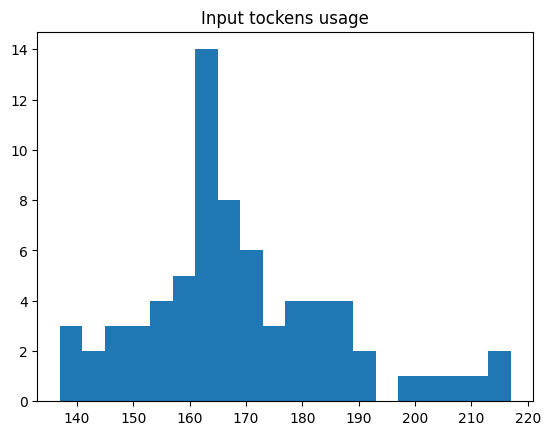

In [39]:
save_results(results, subname="_all_gpt-4o-mini")

tokens_usage = np.array(tokens_usage)
print(f"Mean input tockens: {tokens_usage[:,0].mean():.1f}")
print(f"Mean output tockens: {tokens_usage[:,1].mean():.1f}")
print(f"Total input tockens: {tokens_usage[:,0].sum()}")
print(f"Total output tockens: {tokens_usage[:,1].sum()}")

plt.hist(tokens_usage[:,0], bins=20); plt.title("Input tockens usage");

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def process_line(line, llm_oracle:OPEN_AI_Server, config, onto_src, onto_tgt, one_more_time=True):
    """
    Process a single line: generate a prompt, send it to the LLM, and extract the response.
    """
    try:
        source = line.split('|')[0]
        target = line.split('|')[1]
        prompt = dummy_prompt(OntologyEntryAttr(source, onto_src), OntologyEntryAttr(target, onto_tgt))

        response = llm_oracle.ask_question(prompt, **config)
        input_tokens = response.usage.prompt_tokens
        output_tokens = response.usage.completion_tokens
        resp = extract_answer_openai(response)

        result = f"{source}|{target}|{resp}"
        token_usage = (input_tokens, output_tokens)

        return result, token_usage
    except Exception as e:
        try:
            return f"Error processing line: {line} | {response} | {str(e)}", (input_tokens, output_tokens)
        except:
            if one_more_time:
                return process_line(line, llm_oracle, config, onto_src, onto_tgt, one_more_time=False)
            return f"Error processing line: {line} | No Responce | {str(e)}", (-1, 0)


# def parallel_process_lines(lines, llm_oracle, config, onto_src, onto_tgt, max_workers=4):
#     """
#     Process lines in parallel, with progress tracking using tqdm.
#     """

MAX_WORKERS = 6
results = []
tokens_usage = []
NUM_ROWS = len(lines)

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    future_to_line = {
        executor.submit(process_line, line, llm_oracle, config, onto_src, onto_tgt): line
        for line in lines[:NUM_ROWS]
    }

    for future in tqdm(as_completed(future_to_line), total=len(future_to_line), desc="Processing Lines"):
        result, token_usage = future.result()
        results.append(result)
        tokens_usage.append(token_usage)

    # return results, tokens_usage


# results, tokens_usage = parallel_process_lines(
#     lines, llm_oracle, config, onto_src, onto_tgt, max_workers=16
# )

# Print the results
for result in results:
    print(result)


Processing Lines:   0%|          | 0/1464 [00:00<?, ?it/s]

Processing Lines: 100%|██████████| 1464/1464 [03:34<00:00,  6.81it/s]

http://www.omim.org/phenotypicSeries/PS277400|http://www.orpha.net/ORDO/Orphanet_293355|False
http://omim.org/entry/605479|http://www.orpha.net/ORDO/Orphanet_99961|False
http://omim.org/entry/604536|http://www.orpha.net/ORDO/Orphanet_158668|False
http://www.omim.org/phenotypicSeries/PS200600|http://www.orpha.net/ORDO/Orphanet_932|True
http://omim.org/entry/616354|http://www.orpha.net/ORDO/Orphanet_397709|True
http://omim.org/entry/304050|http://www.orpha.net/ORDO/Orphanet_50|False
http://omim.org/entry/610377|http://www.orpha.net/ORDO/Orphanet_29|False
http://omim.org/entry/613564|http://www.orpha.net/ORDO/Orphanet_261349|False
http://omim.org/entry/311450|http://www.orpha.net/ORDO/Orphanet_2804|True
http://omim.org/entry/602014|http://www.orpha.net/ORDO/Orphanet_30924|False
http://omim.org/entry/610755|http://www.orpha.net/ORDO/Orphanet_276152|False
http://omim.org/entry/615179|http://www.orpha.net/ORDO/Orphanet_352745|False
http://omim.org/entry/607317|http://www.orpha.net/ORDO/Orpha

Mean input tockens: 213.8
Mean output tockens: 5.0
Total input tockens: 313033
Total output tockens: 7320


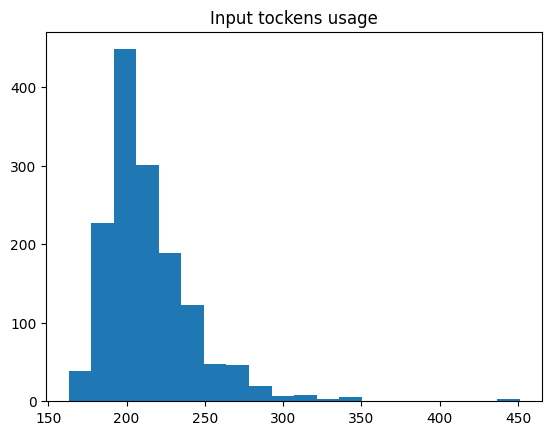

In [49]:
save_results(results, subname="_all_gpt-4o-mini_with_parents")

tokens_usage = np.array(tokens_usage)
print(f"Mean input tockens: {tokens_usage[:,0].mean():.1f}")
print(f"Mean output tockens: {tokens_usage[:,1].mean():.1f}")
print(f"Total input tockens: {tokens_usage[:,0].sum()}")
print(f"Total output tockens: {tokens_usage[:,1].sum()}")

plt.hist(tokens_usage[:,0], bins=20); plt.title("Input tockens usage");

Mean input tockens: 173.7
Mean output tockens: 5.0
Total input tockens: 254226
Total output tockens: 7320


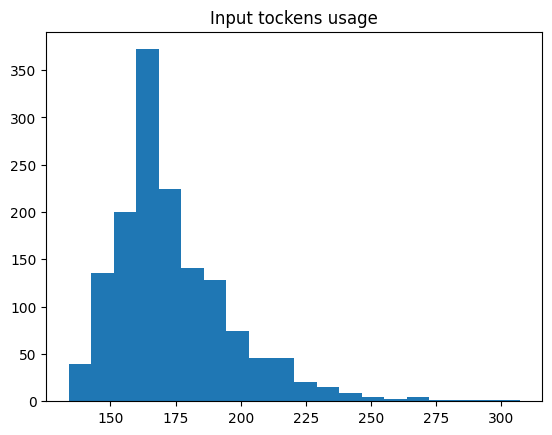

In [43]:
save_results(results, subname="_all_gpt-4o-mini_parallel")

tokens_usage = np.array(tokens_usage)
print(f"Mean input tockens: {tokens_usage[:,0].mean():.1f}")
print(f"Mean output tockens: {tokens_usage[:,1].mean():.1f}")
print(f"Total input tockens: {tokens_usage[:,0].sum()}")
print(f"Total output tockens: {tokens_usage[:,1].sum()}")

plt.hist(tokens_usage[:,0], bins=20); plt.title("Input tockens usage");

## Results analysis

In [19]:
gt_positive_pairs_path = DATASET_PATH / "omim-ordo/refs_equiv/full.tsv"
gt_positive_pairs = pd.read_csv(gt_positive_pairs_path, sep='\t')
gt_positive_pairs.columns = ["Source", "Target", "Label"]
gt_positive_pairs.head()

,Source,Target,Label
0,http://omim.org/entry/609560,http://www.orpha.net/ORDO/Orphanet_254875,1.0
1,http://omim.org/entry/617171,http://www.orpha.net/ORDO/Orphanet_468620,1.0
2,http://omim.org/entry/617173,http://www.orpha.net/ORDO/Orphanet_542306,1.0
3,http://omim.org/entry/617140,http://www.orpha.net/ORDO/Orphanet_500150,1.0
4,http://omim.org/entry/617157,http://www.orpha.net/ORDO/Orphanet_464288,1.0


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def extend_results_with_labels(df, gt_df):
    df["Label"] = False
    for idx, row in gt_df.iterrows():
        source = row['Source']
        target = row['Target']
        mask = (df['Source'] == source) & (df['Target'] == target)
        df.loc[mask, 'Label'] = True
    df['Type'] = df.apply(lambda x: 'TP' if x['Label'] and x['Prediction'] else 'TN' if not x['Label'] and not x['Prediction'] else 'FP' if not x['Label'] and x['Prediction'] else 'FN', axis=1)
    return df


def analyze_results(df, print_results=True, plot_confusion_matrix=True, subtitle=''):
    accuracy = accuracy_score(df['Label'], df['Prediction'])
    precision = precision_score(df['Label'], df['Prediction'])
    recall = recall_score(df['Label'], df['Prediction'])
    f1 = f1_score(df['Label'], df['Prediction'])
    conf_matrix = confusion_matrix(df['Label'], df['Prediction'])

    if print_results:
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")
        
    if plot_confusion_matrix:
        plt.figure(figsize=(4, 4))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'{subtitle}Confusion Matrix')
        plt.show()
    return accuracy, precision, recall, f1, conf_matrix

In [21]:
gpt_mini_predictions = pd.read_csv(RESULTS_DIR / "llm_oracle_results_all_gpt-4o-mini_with_parents.txt", sep='|', header=None)
gpt_mini_predictions.columns = ['Source', 'Target', 'Prediction']
gpt_mini_predictions = extend_results_with_labels(gpt_mini_predictions, gt_positive_pairs)
gpt_mini_predictions

,Source,Target,Prediction,Label,Type
0,http://www.omim.org/phenotypicSeries/PS277400,http://www.orpha.net/ORDO/Orphanet_293355,False,False,TN
1,http://omim.org/entry/605479,http://www.orpha.net/ORDO/Orphanet_99961,False,True,FN
2,http://omim.org/entry/604536,http://www.orpha.net/ORDO/Orphanet_158668,False,True,FN
3,http://www.omim.org/phenotypicSeries/PS200600,http://www.orpha.net/ORDO/Orphanet_932,True,True,TP
4,http://omim.org/entry/616354,http://www.orpha.net/ORDO/Orphanet_397709,True,True,TP
...,...,...,...,...,...
1459,http://omim.org/entry/607736,http://www.orpha.net/ORDO/Orphanet_99943,True,True,TP
1460,http://www.omim.org/phenotypicSeries/PS609192,http://www.orpha.net/ORDO/Orphanet_60030,True,True,TP
1461,http://www.omim.org/phenotypicSeries/PS105650,http://www.orpha.net/ORDO/Orphanet_124,True,True,TP
1462,http://omim.org/entry/609454,http://www.orpha.net/ORDO/Orphanet_683,False,False,TN


Accuracy: 0.66
Precision: 0.89
Recall: 0.65
F1 Score: 0.75


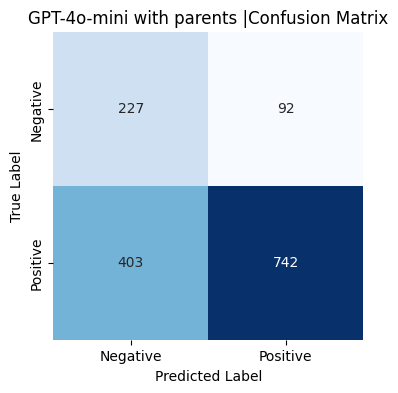

In [22]:
analyze_results(gpt_mini_predictions, print_results=True, plot_confusion_matrix=True, subtitle='GPT-4o-mini with parents |');

Accuracy: 0.66
Precision: 0.89
Recall: 0.65
F1 Score: 0.75


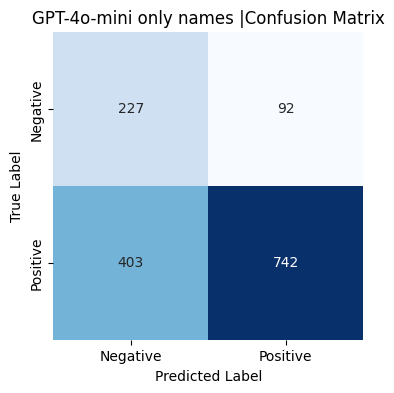

In [23]:
gpt_mini_predictions = pd.read_csv(RESULTS_DIR / "llm_oracle_results_all_gpt-4o-mini_names2.txt", sep='|', header=None)
gpt_mini_predictions.columns = ['Source', 'Target', 'Prediction']
gpt_mini_predictions = extend_results_with_labels(gpt_mini_predictions, gt_positive_pairs)
analyze_results(gpt_mini_predictions, print_results=True, plot_confusion_matrix=True, subtitle='GPT-4o-mini only names |');

Accuracy: 0.83
Precision: 0.88
Recall: 0.89
F1 Score: 0.89


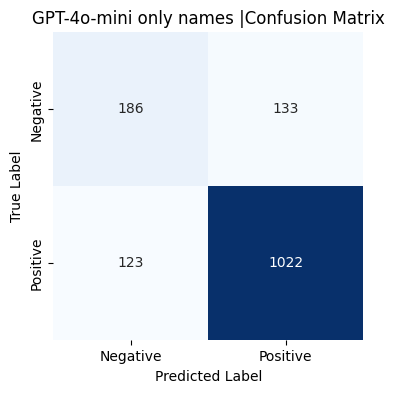

In [24]:
gpt_mini_only_names = pd.read_csv(RESULTS_DIR / "llm_oracle_results_all_gpt-4o-mini_only_names.txt", sep='|', header=None)
gpt_mini_only_names.columns = ['Source', 'Target', 'Prediction']
gpt_mini_only_names = extend_results_with_labels(gpt_mini_only_names, gt_positive_pairs)
analyze_results(gpt_mini_only_names, print_results=True, plot_confusion_matrix=True, subtitle='GPT-4o-mini only names |');

In [25]:
def get_results_df_from_logs(logs_path, do_preprocess=True, sep=' '):
    with open(logs_path, 'r') as file:
        lines = file.readlines()
    results = []
    for line in lines:
        if do_preprocess:
            if len(line.strip().split(sep)) > 3:
                continue
            pair_part = line.strip().split(sep)[-1]
            if not pair_part.startswith("http"):
                print(f"WARN processing line: {pair_part}")
                continue
        else:
            pair_part = line.strip()
        try:
            source, target, prediction = pair_part.split('|')
            results.append((source, target, prediction))
        except:
            print(f"Error processing line: {line}")
            continue
        
    results_df = pd.DataFrame(results, columns=['Source', 'Target', 'Prediction'])
    results_df['Prediction'] = results_df['Prediction'].apply(lambda x: x == 'Yes')
    return results_df

Accuracy: 0.46
Precision: 0.87
Recall: 0.37
F1 Score: 0.52


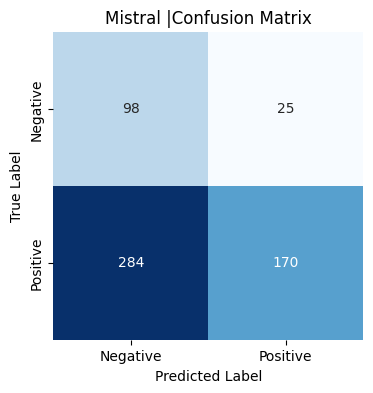

In [27]:
mistral_df = get_results_df_from_logs(RESULTS_DIR / "output_kg_1.txt", do_preprocess=True, sep='\t')
mistral_df = extend_results_with_labels(mistral_df, gt_positive_pairs)
analyze_results(mistral_df, print_results=True, plot_confusion_matrix=True, subtitle='Mistral |');

WARN processing line: 4
WARN processing line: 6
WARN processing line: 13
WARN processing line: 15
WARN processing line: 91
WARN processing line: 95
WARN processing line: 106
WARN processing line: 108
WARN processing line: 116
WARN processing line: 118
WARN processing line: 128
WARN processing line: 135
WARN processing line: 138
WARN processing line: 140
WARN processing line: 145
WARN processing line: 150
WARN processing line: 152
WARN processing line: 154


Accuracy: 0.47
Precision: 0.79
Recall: 0.44
F1 Score: 0.56


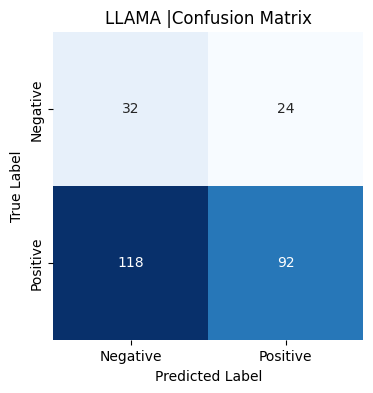

In [28]:
llama_df = get_results_df_from_logs(RESULTS_DIR / "llama_logs.txt")
llama_df = extend_results_with_labels(llama_df, gt_positive_pairs)
analyze_results(llama_df, print_results=True, plot_confusion_matrix=True, subtitle='LLAMA |');

Accuracy: 0.46
Precision: 0.87
Recall: 0.37
F1 Score: 0.52


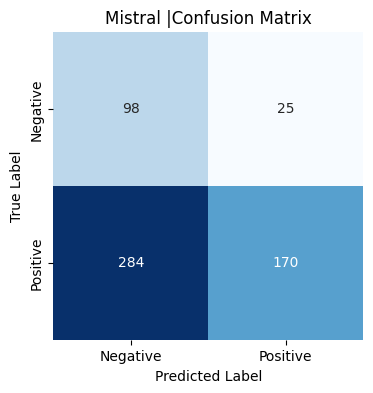

In [29]:
mistral_df = get_results_df_from_logs(RESULTS_DIR / "output_kg_2.txt", do_preprocess=False)
mistral_df = extend_results_with_labels(mistral_df, gt_positive_pairs)
analyze_results(mistral_df, print_results=True, plot_confusion_matrix=True, subtitle='Mistral |');

## analyze false predictions

In [ ]:
def print_results_entry(res_df, pair_type='FP', idx=0):
    source_uri = res_df[res_df['Type'] == pair_type].iloc[idx]['Source']
    target_uri = res_df[res_df['Type'] == pair_type].iloc[idx]['Target']

    source_entry = OntologyEntryAttr(source_uri, onto_src)
    target_entry = OntologyEntryAttr(target_uri, onto_tgt)

    print(f"Processing pair {idx} of type {pair_type}")
    pprint("Source Entry:\n")
    pprint(source_entry.annotation)
    pprint("Target Entry:\n")
    pprint(target_entry.annotation)

    print(f"Parent of Source Concept: {source_entry.getParentsPreferredNames()}")
    print(f"Parent of Target Concept: {target_entry.getParentsPreferredNames()}")

In [123]:
print_results_entry(mistral_df, pair_type='FP', idx=0)

Processing pair 0 of type FP
'Source Entry:\n'
{'children': {entry.615179},
 'class': entry.615179,
 'names': {'albinism, oculocutaneous,  iia 7', 'OCA7'},
 'parents': {phenotypicSeries.PS203100, owl.Thing, entry.615179},
 'synonyms': {'OCA7'}}
'Target Entry:\n'
{'children': {ORDO.Orphanet_352745},
 'class': ORDO.Orphanet_352745,
 'names': {'Oculocutaneous albinism type 7', 'OCA7'},
 'parents': {owl.Thing,
             ORDO.Orphanet_352745,
             ORDO.Orphanet_C001,
             ORDO.Orphanet_377788},
 'synonyms': {'OCA7'}}
Parent of Source Concept: [{'Oculocutaneous albinism'}, {owl.Thing}]
Parent of Target Concept: [{owl.Thing}, {'disease'}, {'clinical entity'}]


In [124]:
print_results_entry(gpt_mini_only_names, pair_type='FP', idx=0)

Processing pair 0 of type FP
'Source Entry:\n'
{'children': {entry.616354},
 'class': entry.616354,
 'names': {'SCAR20', 'spinocerebellar ataxia, autosomal recessive 20'},
 'parents': {entry.616354, owl.Thing, phenotypicSeries.PS213200},
 'synonyms': {'SCAR20'}}
'Target Entry:\n'
{'children': {ORDO.Orphanet_397709},
 'class': ORDO.Orphanet_397709,
 'names': {'Autosomal recessive spinocerebellar ataxia type 20',
           'Intellectual disability-coarse face-macrocephaly-cerebellar '
           'hypoplasia syndrome',
           'Intellectual disability-coarse face-macrocephaly-cerebellar '
           'hypotrophy syndrome',
           'SCAR20'},
 'parents': {owl.Thing,
             ORDO.Orphanet_397709,
             ORDO.Orphanet_C001,
             ORDO.Orphanet_377789},
 'synonyms': {'Autosomal recessive spinocerebellar ataxia type 20',
              'Intellectual disability-coarse face-macrocephaly-cerebellar '
              'hypoplasia syndrome',
              'SCAR20'}}
Parent of So

In [125]:
print_results_entry(gpt_mini_only_names, pair_type='FN', idx=0)

Processing pair 0 of type FN
'Source Entry:\n'
{'children': {entry.272460},
 'class': entry.272460,
 'names': {'SCT', 'spondylocarpotarsal synostosis syndrome'},
 'parents': {owl.Thing, entry.272460},
 'synonyms': {'SCT'}}
'Target Entry:\n'
{'children': {ORDO.Orphanet_3275},
 'class': ORDO.Orphanet_3275,
 'names': {'Spondylocarpotarsal synostosis', 'Synspondylism'},
 'parents': {owl.Thing,
             ORDO.Orphanet_C001,
             ORDO.Orphanet_377789,
             ORDO.Orphanet_3275},
 'synonyms': {'Synspondylism'}}
Parent of Source Concept: [{owl.Thing}]
Parent of Target Concept: [{owl.Thing}, {'malformation syndrome'}, {'clinical entity'}]


In [126]:
print_results_entry(mistral_df, pair_type='FP', idx=1)

Processing pair 1 of type FP
'Source Entry:\n'
{'children': {entry.114000},
 'class': entry.114000,
 'names': {'CAFYD', 'caffey disease'},
 'parents': {entry.114000, owl.Thing},
 'synonyms': {'CAFYD'}}
'Target Entry:\n'
{'children': {ORDO.Orphanet_1310},
 'class': ORDO.Orphanet_1310,
 'names': {'Infantile cortical hyperostosis', 'Caffey disease'},
 'parents': {owl.Thing,
             ORDO.Orphanet_1310,
             ORDO.Orphanet_C001,
             ORDO.Orphanet_377789},
 'synonyms': {'Infantile cortical hyperostosis'}}
Parent of Source Concept: [{owl.Thing}]
Parent of Target Concept: [{owl.Thing}, {'malformation syndrome'}, {'clinical entity'}]


In [127]:
print_results_entry(mistral_df, pair_type='FN', idx=1)

Processing pair 1 of type FN
'Source Entry:\n'
{'children': {entry.304050},
 'class': entry.304050,
 'names': {'aicardi syndrome', 'AIC'},
 'parents': {owl.Thing, entry.304050},
 'synonyms': {'AIC'}}
'Target Entry:\n'
{'children': {ORDO.Orphanet_50},
 'class': ORDO.Orphanet_50,
 'names': {'Agenesis of corpus callosum with chorioretinal abnormality',
           'Aicardi syndrome'},
 'parents': {owl.Thing,
             ORDO.Orphanet_50,
             ORDO.Orphanet_C001,
             ORDO.Orphanet_377788},
 'synonyms': {'Agenesis of corpus callosum with chorioretinal abnormality'}}
Parent of Source Concept: [{owl.Thing}]
Parent of Target Concept: [{owl.Thing}, {'clinical entity'}, {'disease'}]
